# Scientific Python

`scipy` is a package built on top of `numpy` to provide more specialized functionality such as interpolation, curve fitting, root finding and so forth.
When working with measurement data the before mentioned topics are very frequently used, so we'll take a closer look on how to make use of the `scipy` package to solve these sorts of problems.
To import basic functionality from the `scipy` package we follow a well known pattern.

In [236]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

sns.set()

## Interpolation

Functions to aid for data interpolation are available in a sub package of `scipy` called `interpolate`.
We import a function suited for 1 dimensional interpolation from this subpackage called `interp1d`

In [237]:
from scipy.interpolate import interp1d

The function can take various arguments. At least two tuples are necessary defining a source value range and a target value range the source data is mapped to. This is already enough to create a simple linear model to be used like this.

In [238]:
value_mapper = interp1d((-10, 10), (0, 100))

This defines a linear mapper for source values in the range of -10 to 10, which are mapped to a linear range between 0 and 100. Let's check this with the center position of the source model.

In [239]:
value_mapper(0)

array(50.)

We receive the expected value of 50. Notice though that the result type is an `array`. The mapper is able to work with data organized in arbitrary dimension. So when a single value is used, we have to "reduce" the array down to a single value for example by using the `float` function.

In [240]:
float(value_mapper(0))

50.0

As mentioned the mapper will be able to handle more than a single value for input. For example this can be used to check the boundary values for the source values and the center.

In [241]:
value_mapper([-10, 0, 10])

array([  0.,  50., 100.])

When trying to use values outside the source range, we receive an error though

In [242]:
value_mapper(-20)

ValueError: A value in x_new is below the interpolation range.

This is because of the defaults settings chosen for the `interp1d` function. Using the `help` function in `interp1d` shows that there are ways to make this work.

In [243]:
help(interp1d)

Help on class interp1d in module scipy.interpolate.interpolate:

class interp1d(scipy.interpolate.polyint._Interpolator1D)
 |  interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
 |  
 |  Interpolate a 1-D function.
 |  
 |  `x` and `y` are arrays of values used to approximate some function f:
 |  ``y = f(x)``. This class returns a function whose call method uses
 |  interpolation to find the value of new points.
 |  
 |  Parameters
 |  ----------
 |  x : (N,) array_like
 |      A 1-D array of real values.
 |  y : (...,N,...) array_like
 |      A N-D array of real values. The length of `y` along the interpolation
 |      axis must be equal to the length of `x`.
 |  kind : str or int, optional
 |      Specifies the kind of interpolation as a string or as an integer
 |      specifying the order of the spline interpolator to use.
 |      The string has to be one of 'linear', 'nearest', 'nearest-up', 'zero',
 |      'slinear', 'quadrati

Re-defining the value_mapper to disable the `bounds_error` parameter, will make the function no longer throw an error when called within source values outside its defined range. However the output might still not be the desired one.

In [246]:
value_mapper = interp1d((-10, 10), (0, 100), bounds_error=False)

In [247]:
value_mapper(-20)

array(nan)

The output is the special value `nan`, which stands for Not a Number. If we desire to have a usable output, we need to define how our interpolation function should behave in areas outside of the source range.
One suitable way would be to just return the limits of the interpolation range.

In [248]:
value_mapper = interp1d((-10, 10), (0, 100), bounds_error=False, fill_value=(0, 100))

In [249]:
value_mapper(-20)

array(0.)

In [250]:
value_mapper(20)

array(100.)

Another useful strategy can be extrapolating, when the data used to define the model is actually only a center subset of a valid larger linear model. 

In [251]:
value_mapper = interp1d(
    (-10, 10), (0, 100), bounds_error=False, fill_value="extrapolate"
)

In [252]:
value_mapper(-20)

array(-50.)

In [253]:
value_mapper(20)

array(150.)

Interpolation models will not always be that simple in reality.
If a piece wise defined model more accurately defines the data, the source and target tuples can simply be extended.
The following example shows a much more complex model in this regard and a quick test covering the input range in steps of 2.

In [257]:
value_mapper = interp1d((-20, -10, 0, 10, 20), (10, 0, 0, 100, 500))

In [258]:
value_mapper(list(range(-20, 20, 2)))

array([ 10.,   8.,   6.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
        20.,  40.,  60.,  80., 100., 180., 260., 340., 420.])

But it doesn't stop here. Another very powerful parameter for the `interp1d` function is the `kind` parameter, which allows you to switch from the default linear regression model to one of the defined other options, which includes a *nearest neighbor* approach and *quadratic* and *cubic* relations to be used for interpolation. Note that the number of elements necessary for these other models needs to fit the mininum number of required parameters to these functions to make these options work. 

## Curve fitting

Another frequently used topic in data evaluation is curve fitting.
An example here could be to analyze measured data for certain parameters expected due to a known model being the source of the data.

Let's create an already complex dataset to play with for learning how to perform proper curve fitting using `scipy` here. 

Let's say we measured some data using an A/D converter for 10 seconds with a sample rate of 100 Hz.
The data measured should look sinusoidal with an amplitude of 6 Volts and a frequency of 3 Hz. There should also be a voltage offset be involved of 5 Volts as well as a rather arbitrary phase shift as we started to perform the mesurements at some unspecific point in time in the middle of a running experiment. In this case the value of the phase shift will be $\pi/2$.
Further more the data will be a bit noisy based on the sensors quality we used.

We can model the data measurement simulation like the following.


In [260]:
simulation_length = 10.0
dt = 0.01
ts_values = np.arange(0, simulation_length, dt)

amplitude = 6.0
offset = 5.0
frequency = 3.0
phase = np.pi / 2.0

sin_values = amplitude * np.sin(frequency * np.pi * (ts_values - phase)) + offset

noise_level = 2.5
data = sin_values + np.random.uniform(-noise_level, noise_level, sin_values.shape)

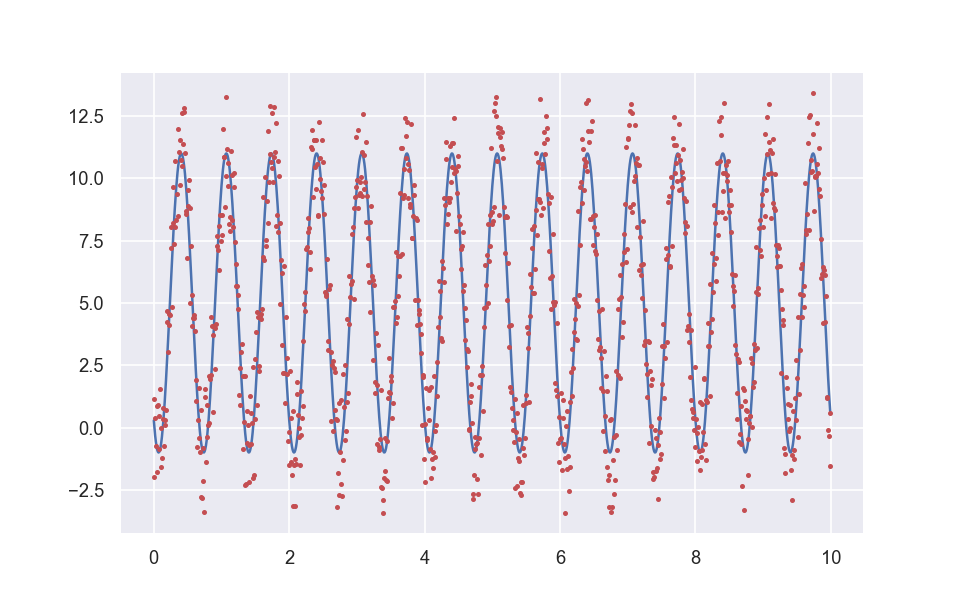

In [261]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=120)
axes.plot(ts_values, sin_values, "b-")
axes.plot(ts_values, data, "ro", markersize=2)

So our aim is to reproduce the blue *ideal* data from the *measured* red ones.

Curve fitting is essentially an optimization problem, where parameters get optimized to reduce an error up until the resulting error drops below an acceptable threshold. 

`scipy`s solution for curve fitting is called `curve_fit`, and is available in the `optimize` sub-package.

In [202]:
from scipy.optimize import curve_fit

The `curve_fit` function expects at least three parameters.
First is a model to be optimized, second is the array of x values, so our timestamp array in this case, and last but not least the data to fit. 

To make this all work we have to define a function describing our model. A special calling signature is required here as well, starting with the base, the x values, and following all necessary parameters that need to be considered.
A valid definition for our problem would be

In [262]:
def model(x, a, f, p, o):
    return a * np.sin(f * np.pi * (x - p)) + o

With this being done, we can already run the curve fitting process like this.

In [263]:
popt, pcov = curve_fit(model, ts_values, data)

The return values of the `curve_fit` call are an array of optimized parameters and the covariance values derived from the fitting process, a measure for result quality.
Looking at the result of the fitting by printing the popt variable shows that we might not have been very successful in fitting our model.

In [265]:
popt

array([-0.21370286,  1.49398811,  3.51813444,  4.98888869])

Let's have a closer look by viewing the results graphically.

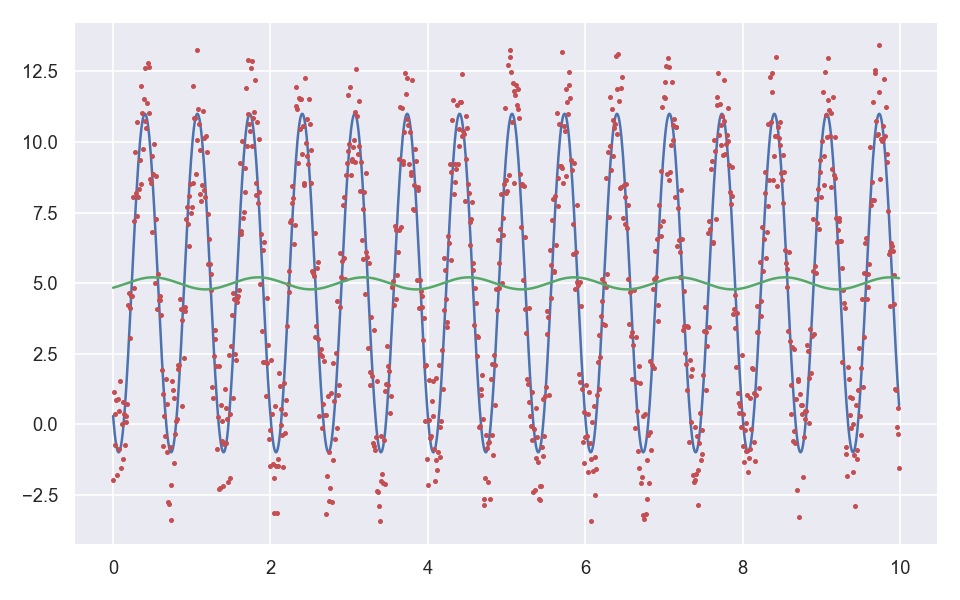

In [266]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=120)
axes.plot(ts_values, sin_values, "b-")
axes.plot(ts_values, data, "ro", markersize=2)
axes.plot(ts_values, model(ts_values, *popt), "g-")
plt.tight_layout()

The green curve shows our result here. Not very satisfying.

The reason for the bad result quality here is the periodical nature of the sine model behind the data. Indeed the set of fitted parameters is a better choice for the model than other scenarios. It indeed minimizes the error. Varying one of the parameters in either possible direction increases the overall error to gain worse results. We've found a local minimum when reducing the error. A slight jump in one of the parameters during optimization might have brought us out of the trap. But that's what it is.

There are ways to support the algorithm however. One possible way is to set some starting points for the parameters to optimize. The close we are to the real values here, the better the result will be of course. For example choosing the following parameters will lead to a much better and acceptable result.

In [274]:
popt, pcov = curve_fit(model, ts_values, data, p0=[1, 3, 1, 1])
popt

array([6.03955008, 3.0005259 , 0.90454561, 4.99516675])

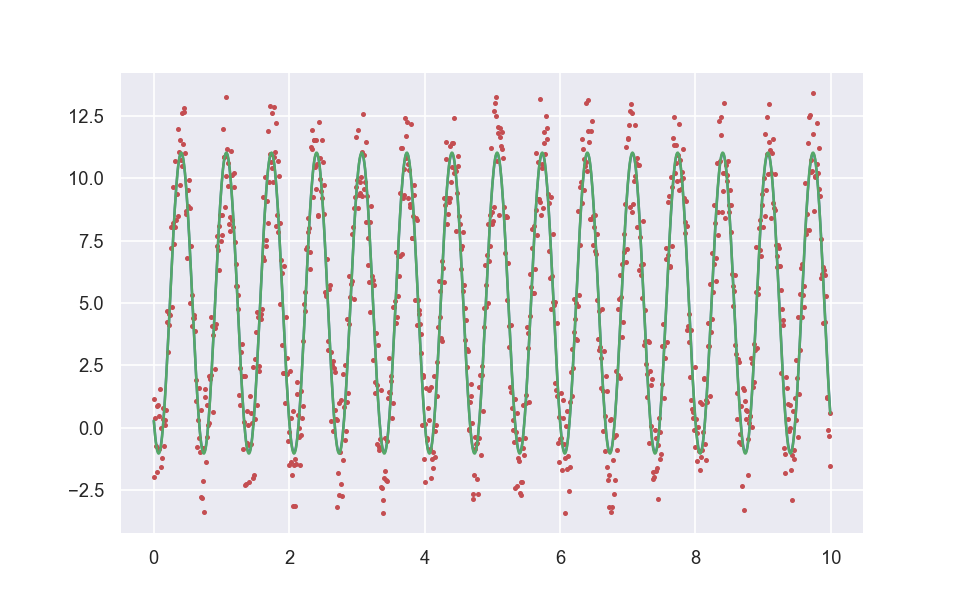

In [275]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=120)
axes.plot(ts_values, sin_values, "b-")
axes.plot(ts_values, data, "ro", markersize=2)
axes.plot(ts_values, model(ts_values, *popt), "g-")

It looks a bit like cheating though, as the frequency is exactly specified. This is also the most dominant part in our model.

Another suitable method is to define bounds for the parameters. You can do this by specifying a two element tuple of iterables. One for all lower bounds to a parameter, one for the upper bound. That's a more realistic scenario for fitting this model in practice.

In [276]:
popt, pcov = curve_fit(
    model, ts_values, data, bounds=((1, 1, 0, -10), (10, 5, np.pi, 10))
)
popt

array([6.03955008, 3.00052589, 1.57109541, 4.99516673])

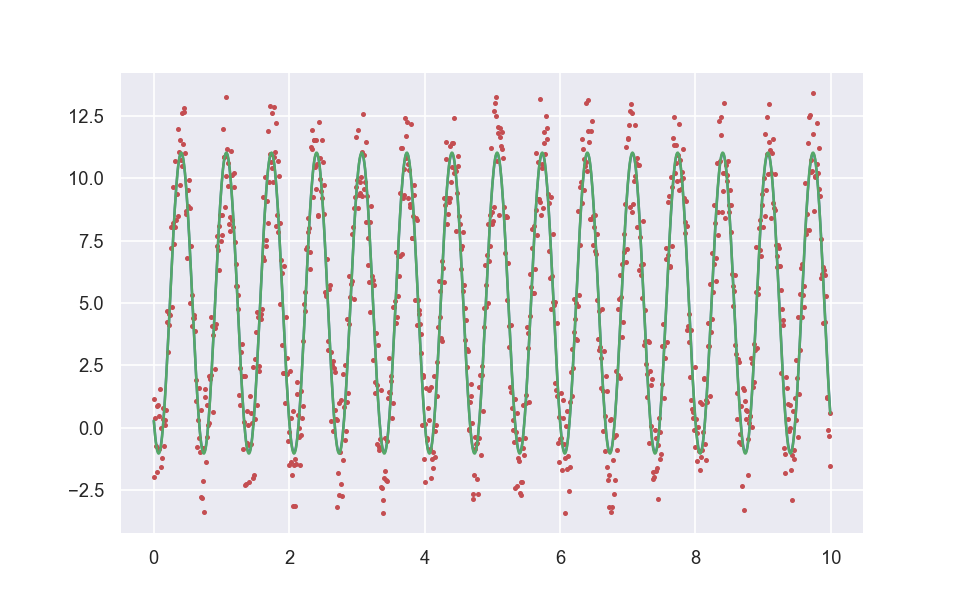

In [277]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=120)
axes.plot(ts_values, sin_values, "b-")
axes.plot(ts_values, data, "ro", markersize=2)
axes.plot(ts_values, model(ts_values, *popt), "g-")

And the result quality is quite good and totally acceptable to work with.

## Root finding

In [298]:
from scipy.optimize import newton, bisect
import scipy.optimize as so

In [315]:
def f_model(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d

In [333]:
x = np.arange(-2, 2.5, .1)

In [338]:
f = lambda x: f_model(x, 1, -1, -2, 0)

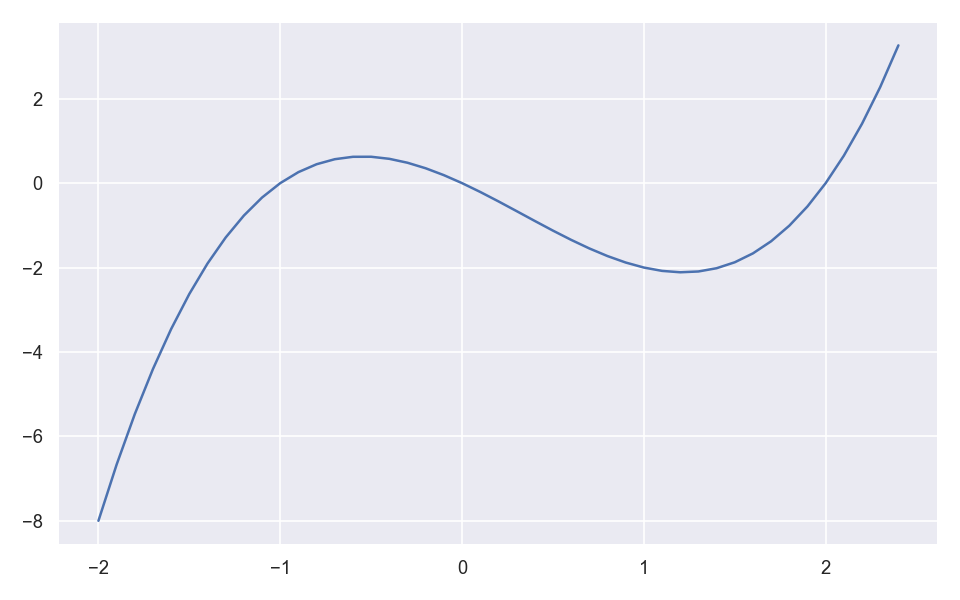

In [339]:
fig, axes = plt.subplots(figsize=(8,5), dpi=120)
axes.plot(x, f(x), "b-")
plt.tight_layout()

In [360]:
x_pos = newton(f, -5)


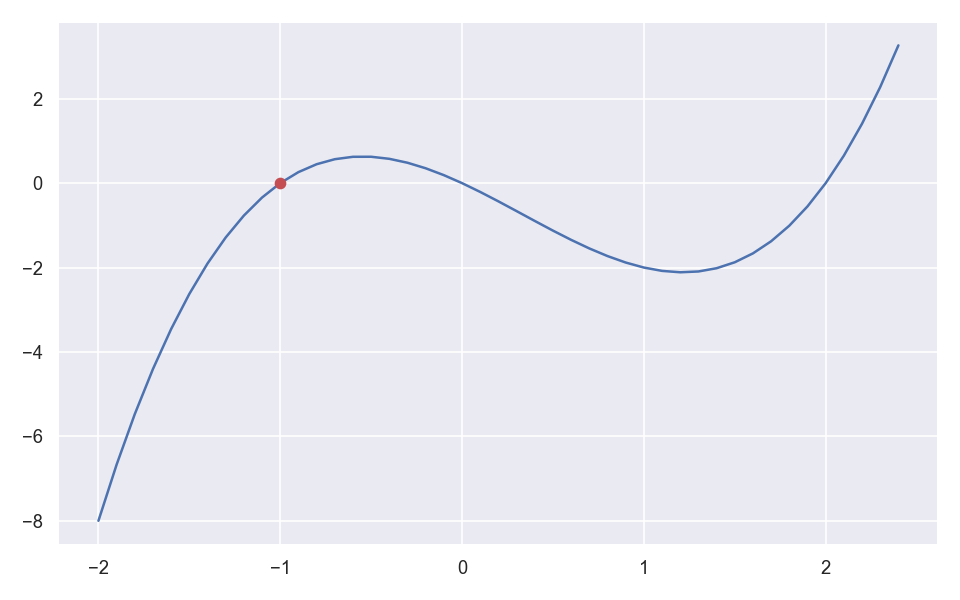

In [362]:
fig, axes = plt.subplots(figsize=(8,5), dpi=120)
axes.plot(x, f(x), "b-")
axes.plot(x_pos, 0, "ro")
plt.tight_layout()